# Revisit the internal structures

All the steps will be checked using DEBUG enabled.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from results.cliques_discovery import *
from results.helpers import *

In [3]:
import sys
import logging
logging.basicConfig(format='%(funcName)s:%(levelname)s:%(message)s', level=logging.ERROR, stream=sys.stdout)

In [4]:
# Be a "trace" a sequence over a finite alphabet A
# Be T a collection of traces on A
def cliques_discovery(T):
    
    DAG_allTraces = None # Void graph
    all_loops = {}       # No sequences
    
    for trace in T:

        # --------------------------------------------
        # (1) Calculate the successors (u,v_0), (u, v_1) ...  only for this trace, 
        # --------------------------------------------        
        # (1.1) Get successors and count its frequency
        succ_f = get_successor_by_freq([trace])

        # (1.2) Create the graph of successors, with edges weighted with its frequency (u, v, freq)
        succ_G = successorsGraph( succ_f )

        # --------------------------------------------
        # (2) Build the associated unentangled DAG and remove the loops
        # --------------------------------------------
        # (2.1) using cliques, detect all longest single paths [u_0, u_1, ..., u_m]
        paths_this_trace = infer_paths( split_in_freqGraphs(  succ_G  ) )

        # (2.2) Detect and remove loops (saving for later) by computing raw paths that behaves as loops and return associated DAG.
        loops_this_trace, succ_DAG = remove_loops_in_trace(paths_this_trace, succ_G)
        
        # (2.3) Add loops found in this pair to the loops in all traces
        all_loops = remember_loops( loops_this_trace, all_loops )
        
        # (2.4) Unentanglement. The graph should be now 1-cycle free. So, let's remove any parasite 1-cycle (u,v) (v,u) still in succ_DAG!
        succ_DAG_unentangled = unentangled_DAG( succ_DAG )
#         succ_DAG_unentangled = succ_DAG
        
        # --------------------------------------------
        # (3) Combine with previous unentangled DAGs
        # --------------------------------------------
        DAG_allTraces = combine_DAGs(succ_DAG_unentangled, DAG_allTraces)

    # --------------------------------------------
    # (4) Minimize all DAGs and recover loops info
    # --------------------------------------------

    # (4.1) Extract single paths using cliques. Note that this is the same than step (2.1)
    single_paths = infer_paths( split_in_freqGraphs( DAG_allTraces ) )
    
    # (4.2) Build the graph of paths and minimize it: if paths (u,z,v) and (u,v) exists, leave just (u,z,v)
    G = minimally_connected( path_graph( single_paths ) )
    
    # (4.3) Recover loops info , perhaps based on some threshold...
    # PENDING!!
    
    return single_paths, all_loops, G


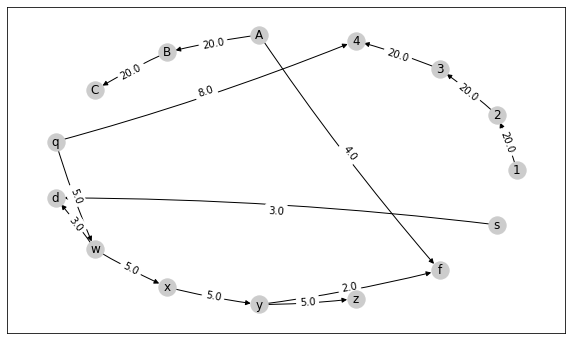

Paths: 
 {2.0: [['x', 'f'], ['q', 'f'], ['w', 'f'], ['y', 'f']], 3.0: [['w', 'd'], ['s', 'd']], 4.0: [['A', 'f']], 5.0: [['q', 'w', 'x', 'y', 'z']], 8.0: [['q', '4']], 19.0: [['q', 'd']], 20.0: [['1', '2', '3', '4'], ['A', 'B', 'C']]}
Loops: 
 {('s', 'd'): 3.0, ('A', 'f'): 4.0, ('1', '2', '3', '4'): 20.0, ('A', 'B', 'C'): 20.0, ('q', 'w', 'x', 'y', 'z'): 4.0}


In [5]:
# Single path ABC 1234 qwxyz noise(sfd)
T = [
    list("AsBC123q41234AwBdCABCxy1234f1234AsBzCABdC123412s34ABCAfBC123d41234ABC"),
    list(""),
    list("qw1xABC23yz41qwxyz2A3B4CAq1B23w4Cx12Ay3B4CzAsBfC1q2f34123d4AwBdCABC1234f1234ABCABxyzdC123412s34ABCABC123d412f34ABfC"),
    list(""),
    list("")
]
pretty ( cliques_discovery(T) )

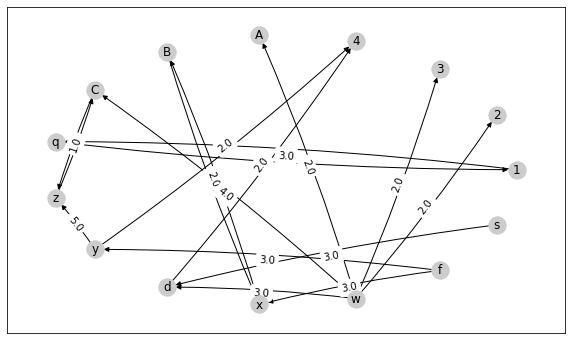

Paths: 
 {1.0: [['C', '4'], ['z', 'C', '2'], ['1', 'q'], ['z', 'C', '3']], 2.0: [['x', '2'], ['1', 'x', 'A'], ['x', 'B'], ['x', 'C'], ['x', '4', 'f'], ['x', '3', 'f'], ['w', '3', 'f'], ['w', 'B'], ['w', 'A'], ['w', '2'], ['d', '4', 'f'], ['y', '4', 'f'], ['q', 'A'], ['q', 'f']], 3.0: [['4', 'C'], ['q', '1'], ['f', 'x'], ['w', 'd'], ['s', 'd'], ['2', 'C', 'z'], ['3', 'C', 'z'], ['f', 'z'], ['f', 'y'], ['2', 'y']], 4.0: [['A', '4'], ['w', '4'], ['B', '4'], ['2', 'f'], ['1', 'z'], ['1', 'y'], ['1', 'B'], ['1', 'C'], ['1', 'f'], ['w', 'C'], ['A', 'f'], ['A', '3'], ['q', 'C'], ['q', 'B']], 5.0: [['A', 'x'], ['q', 'w', 'x', 'y', 'z'], ['B', 'x']], 6.0: [['q', 'd'], ['B', 'y']], 8.0: [['A', 'z'], ['A', 'y'], ['B', 'z']], 10.0: [['q', '3'], ['q', '2']], 18.0: [['q', '4']], 20.0: [['1', '2', '3', '4'], ['A', 'B', 'C']]}
Loops: 
 {('s', 'd'): 3.0, ('A', 'f'): 4.0, ('1', '2', '3', '4'): 16.0, ('A', 'B', 'C'): 16.0, ('3', '4', 'f'): 2.0, ('A', '3', '4', 'C'): 2.0, ('A', 'B', '4', 'C'): 2.0, ('1', 

In [6]:
# Same as before but splitted
# Single path ABC 1234 qwxyz noise(sfd)
T = [
    list("AsBC123q41234AwBdCABCxy1234f1234AsBzCABdC123412s34ABCAfBC123d41234ABC"),
    list("AsBfC1q2f34123d4AwBdCABC1234f1234ABCABxyzdC123412s34"),
    list("ABCABC123d412f34ABfC"),
    list("qw1xABC23yz4"),
    list("1qwxyz2A3B4C"),
    list("Aq1B23w4Cx12Ay3B4Cz")
]
pretty ( cliques_discovery(T) )

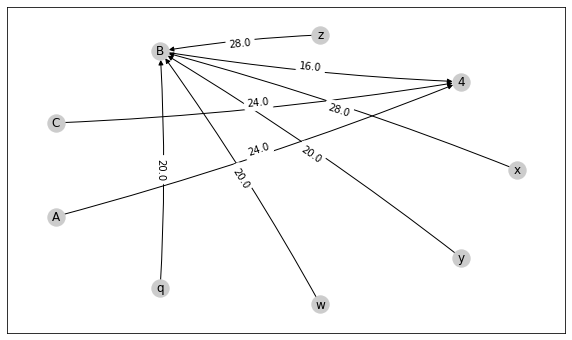

Paths: 
 {16.0: [['B', '4']], 24.0: [['C', '4'], ['A', '4']], 28.0: [['x', '4'], ['z', '4'], ['x', 'B'], ['z', 'B']], 20.0: [['q', '4'], ['w', '4'], ['y', '4'], ['q', 'B'], ['w', 'B'], ['y', 'B']]}
Loops: 
 {}


In [7]:
T = [
    ['z', 'C', '3', 'z', 'C', '2', '1', 'x', 'A', '1', 'x', 'A', 'q', 'w', 'x', 'y', 'z', 'q', 'w', 'x', 'y', 'z', 'q', 'w', 'x', 'y', 'z', 'q', 'w', 'x', 'y', 'z', 'q', 'w', 'x', 'y', 'z', 
     'A', 'B', 'C', 'A', 'B', 'C', 'A', 'B', 'C', 'A', 'B', 'C', '1', '2', '3', '4', '1', '2', '3', '4', '1', '2', '3', '4', '1', '2', '3', '4' ]
]
pretty ( cliques_discovery(T) )

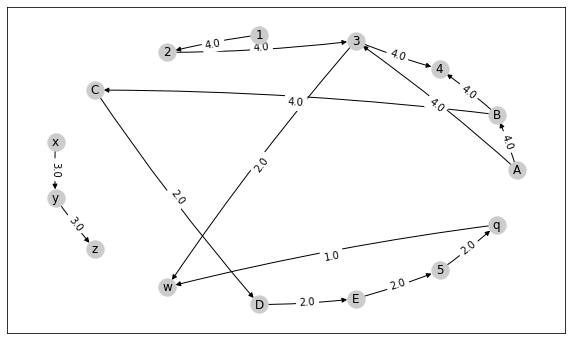

Paths: 
 {1.0: [['q', 'w']], 2.0: [['3', 'w'], ['A', 'D', 'E', '5', 'w'], ['B', 'D', 'E', '5', 'w'], ['2', 'w'], ['1', 'w'], ['C', 'D', 'E', '5'], ['D', 'E', '5', 'q']], 3.0: [['x', 'y', 'z']], 4.0: [['A', 'B', '4'], ['A', '3', '4'], ['1', '2', '3', '4'], ['A', 'B', 'C']]}
Loops: 
 {('D', 'E', '5'): 2.0, ('2', 'w'): 2.0, ('1', 'w'): 2.0, ('A', 'w'): 2.0, ('3', 'w'): 2.0, ('B', 'w'): 2.0, ('C', 'D', 'E', '5'): 2.0, ('A', 'D', 'E', '5'): 2.0, ('B', 'D', 'E', '5'): 2.0, ('1', '2', '3', '4'): 4.0, ('x', 'y', 'z'): 3.0, ('A', '3', '4'): 4.0, ('A', 'B', '4'): 4.0, ('A', 'B', 'C'): 4.0}


In [45]:
# Single path ABC 1234 qwxyz noise(sfd)
T = [
#     list("ABCDExyz"),
#     list("12345xyz"),
#     list("ABCDE12345"),
#     list("qA1B23w4Cx12Ay3B4Cz")
    list("ABCDExyz12345xyzABCDE12345qA1B23w4Cx12Ay3B4Cz"),
    list(""),
    list(""),
    list("")
]
pretty ( cliques_discovery(T) )

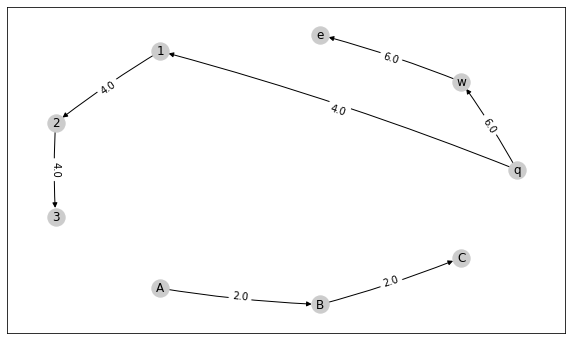

Paths: 
 {2.0: [['A', 'B', 'C']], 4.0: [['q', '1', '2', '3']], 6.0: [['q', 'w', 'e']]}
Loops: 
 {('A', 'B', 'C'): 2.0, ('q', '1', '2', '3'): 4.0, ('q', 'w', 'e'): 6.0}


In [43]:
# ABCD
T = [
#     list("ABCDE123123123"),
#     list("123123123ABCDE"),
#     list("123123ABCDEABCDE")
    list("123qweq123weqweABC123qweq123weqweABC")
]
pretty ( cliques_discovery(T) )

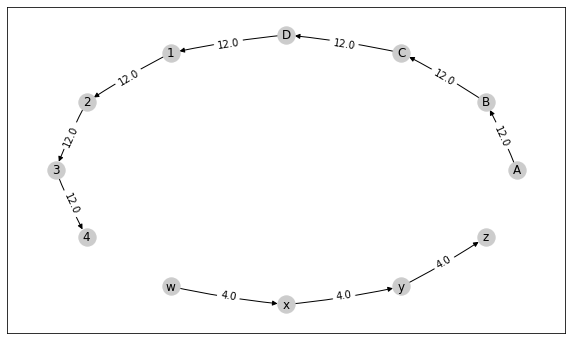

Paths: 
 {12.0: [['A', 'B', 'C', 'D', '1', '2', '3', '4']], 4.0: [['w', 'x', 'y', 'z']]}
Loops: 
 {('A', 'B', 'C', 'D', '1', '2', '3', '4'): 12.0, ('w', 'x', 'y', 'z'): 4.0}


In [40]:
# ABCD 1234 wxyz
T = [
#     list("ABwCD1x2y34ABCDz123w4ABCD1234ABCDx123y4ABCD1z234ABCD1234"),
    list("ABwCD1x2y34ABCDz123w4ABCD1234ABCDx123y4ABCD1z234ABCD1234ABwCD1x2y34ABCDz123w4ABCD1234ABCDx123y4ABCD1z234ABCD1234"),
#     list("1wxAyzBCD234A1B2C3D4"),
#     list("12ABCD34"),
#     list("A1234BCD"),
#     list("1234ABCD")
]
pretty ( cliques_discovery(T) )

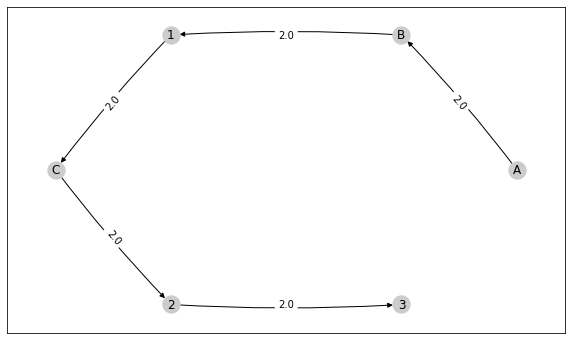

Paths: 
 {2.0: [['A', 'B', '1', 'C', '2', '3']]}
Loops: 
 {('A', 'B', '1', 'C', '2', '3'): 2.0}


In [47]:
# ABC (commmon) 1234 | wxyz DEF(common)
T = [
    list("AB1C23AB1C23"),

]
pretty ( cliques_discovery(T) )

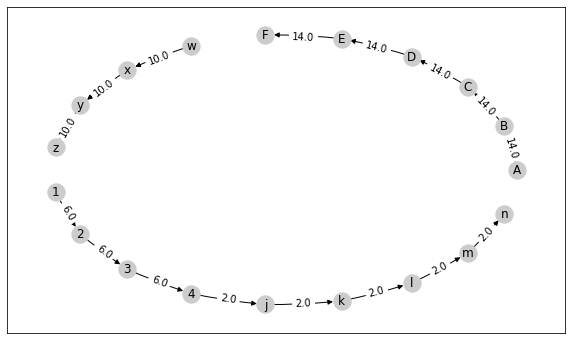

Paths: 
 {2.0: [['2', 'j', 'k', 'l', 'm', 'n'], ['4', 'j', 'k', 'l', 'm', 'n'], ['3', 'j', 'k', 'l', 'm', 'n'], ['1', 'j', 'k', 'l', 'm', 'n']], 10.0: [['w', 'x', 'y', 'z']], 6.0: [['1', '2', '3', '4']], 14.0: [['A', 'B', 'C', 'D', 'E', 'F']]}
Loops: 
 {('j', 'k', 'l', 'm', 'n'): 2.0, ('2', 'j', 'k', 'l', 'm', 'n'): 2.0, ('4', 'j', 'k', 'l', 'm', 'n'): 2.0, ('3', 'j', 'k', 'l', 'm', 'n'): 2.0, ('1', 'j', 'k', 'l', 'm', 'n'): 2.0, ('1', '2', '3', '4'): 6.0, ('w', 'x', 'y', 'z'): 10.0, ('A', 'B', 'C', 'D', 'E', 'F'): 14.0}


In [33]:
# ABC (commmon) 1234 | wxyz DEF(common)
T = [
#     list("jklmnABC1234DEFABCDwxyzEFABCwxyDEzFABC1234DEFABCDwxyzEFABCwxyDEzFABCw1xD23yEFz4"),
#     list("1234"),
    list("jklmnABC1234DEFABCDwxyzEFABCwxyDEzFABC1234DEFABCDwxyzEFABCwxyDEzFABCw1xD23yEFz4jklmnABC1234DEFABCDwxyzEFABCwxyDEzFABC1234DEFABCDwxyzEFABCwxyDEzFABCw1xD23yEFz4"), 
]
pretty ( cliques_discovery(T) )

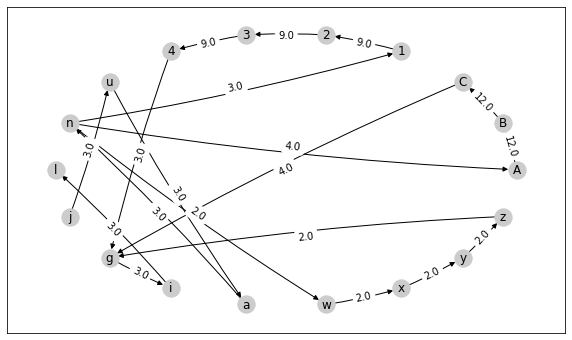

Paths: 
 {2.0: [['u', 'w', 'x', 'y', 'z'], ['n', 'w', 'x', 'y', 'z'], ['w', 'x', 'y', 'z', 'l'], ['j', 'w', 'x', 'y', 'z'], ['w', 'x', 'y', 'z', 'g'], ['w', 'x', 'y', 'z', 'i'], ['a', 'w', 'x', 'y', 'z']], 3.0: [['j', 'u', 'a', 'n', '2', 'g', 'i', 'l'], ['j', 'u', 'a', 'n', '4', 'g', 'i', 'l'], ['j', 'u', 'a', 'n', '3', 'g', 'i', 'l'], ['j', 'u', 'a', 'n', '1', 'g', 'i', 'l']], 4.0: [['u', 'A'], ['n', 'A'], ['A', 'l'], ['j', 'A'], ['A', 'g'], ['A', 'i'], ['a', 'A'], ['u', 'B'], ['n', 'B'], ['B', 'l'], ['j', 'B'], ['B', 'g'], ['B', 'i'], ['a', 'B'], ['u', 'C'], ['n', 'C'], ['C', 'l'], ['j', 'C'], ['C', 'g'], ['C', 'i'], ['a', 'C']], 9.0: [['1', '2', '3', '4']], 12.0: [['A', 'B', 'C']]}
Loops: 
 {('w', 'x', 'y', 'z'): 2.0, ('1', '2', '3', '4'): 9.0, ('A', 'B', 'C'): 12.0, ('j', 'u', 'a', 'n', 'g', 'i', 'l'): 2.0}


In [28]:
# ABC (commmon) 1234 | xyz
T = [
    list("juanABC1234ABC1234ABCwxyzABC1w2x3y4zgil"),
    list("juanABC1234ABC1234ABCwxyzABC1w2x3y4zgiljuanABC1234ABC1234ABCwxyzABC1w2x3y4zgil")
]
pretty ( cliques_discovery(T) )

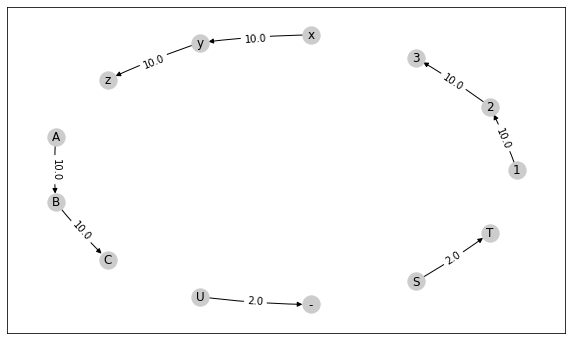

Paths: 
 {10.0: [['1', '2', '3'], ['x', 'y', 'z'], ['A', 'B', 'C']], 2.0: [['U', '-'], ['S', 'T']]}
Loops: 
 {('S', 'T'): 2.0, ('1', '2', '3'): 10.0, ('x', 'y', 'z'): 10.0, ('A', 'B', 'C'): 10.0}


In [25]:
# ABC STU 123 xyz  - complete merging of disjoint sequences
T = [
    list("ABC123xySzxyz123ABCTxyzAUBC123A1xB2yC3z-A1xB2yC3zA1xB2yC-3zA1xB2yC3zA1xB2yC3zSA1xB2yC3zA1xB2TyC3z"), 
]
pretty ( cliques_discovery(T) )